<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_Result_deeper_gru_failure_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)
        
        self.gru_2 = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        output_tensor, _ = self.gru_2(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, H, batch_first=True)
        
        self.gru_2 = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)
        
        output_tensor, _ = self.gru_2(output_tensor)
        
        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [15]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [17]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [26]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_deep_2.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_deep_2.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-02 12:57:27
Mean Train Loss: 0.09957087394239127
Mean Evaluation Loss: 0.0780168877649898
-------------------------------------------------------------------------------------------------------
09-02 12:58:52
Mean Train Loss: 0.07631265571858867
Mean Evaluation Loss: 0.07730362117136658
-------------------------------------------------------------------------------------------------------
09-02 13:00:18
Mean Train Loss: 0.07543179876901446
Mean Evaluation Loss: 0.07594509209614624
-------------------------------------------------------------------------------------------------------
09-02 13:01:43
Mean Train Loss: 0.07460698257996004
Mean Evaluation Loss: 0.07480524591606405
-------------------------------------------------------------------------------------------------------
09-02 13:03:09
Mean Train Loss: 0.07378005870902384
Mean Evaluation Loss: 0.07393705156222052
-----------------------------------------------------------------------------------------------------

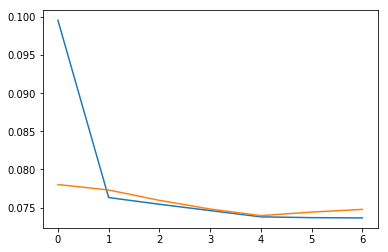

아------------------------------------------------------------------------------------------------------------------------ᆻ다.-----------------------------------------------------------<eos><eos>
았다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


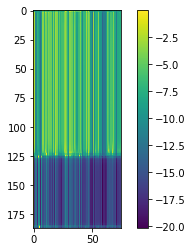

아-------------------------------------------------------------------------------------------------------ᆻ다.-----------------------------------------------<eos><eos>
았다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


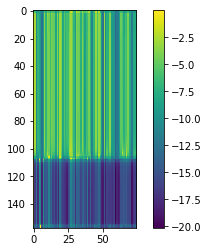

-------------------------------------------------------------------------------------------------------
09-02 13:07:26
Mean Train Loss: 0.07346915331608599
Mean Evaluation Loss: 0.07354375886015622
-------------------------------------------------------------------------------------------------------
09-02 13:08:51
Mean Train Loss: 0.07305837698596654
Mean Evaluation Loss: 0.07377380288839569
-------------------------------------------------------------------------------------------------------
09-02 13:10:16
Mean Train Loss: 0.07305226128187281
Mean Evaluation Loss: 0.07395457888144896
-------------------------------------------------------------------------------------------------------
09-02 13:11:41
Mean Train Loss: 0.07308736754141021
Mean Evaluation Loss: 0.07402032824628106
-------------------------------------------------------------------------------------------------------
09-02 13:13:06
Mean Train Loss: 0.07321940841970369
Mean Evaluation Loss: 0.07381438269194747
----------

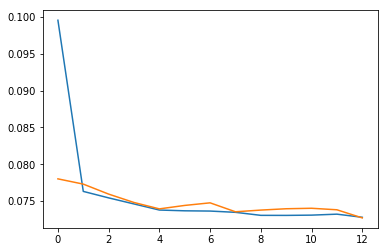

아ᄂ-------------------------------------------------------------------------------------------------------------------------------이아.---------------------------------<eos><eos>
아ᄂ이아.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


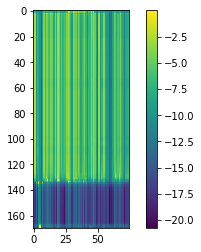

아ᄂ----------------------------------------------------------------------------------------------------어요.------------------------------------------------<eos><eos>
아ᄂ어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


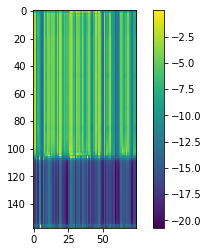

-------------------------------------------------------------------------------------------------------
09-02 13:15:56
Mean Train Loss: 0.07305445623754822
Mean Evaluation Loss: 0.07624336882341679
-------------------------------------------------------------------------------------------------------
09-02 13:17:21
Mean Train Loss: 0.07415655901167517
Mean Evaluation Loss: 0.07642054364370339
-------------------------------------------------------------------------------------------------------
09-02 13:18:46
Mean Train Loss: 0.07422084253000942
Mean Evaluation Loss: 0.0756331066925074
-------------------------------------------------------------------------------------------------------
09-02 13:20:11
Mean Train Loss: 0.07390526524769568
Mean Evaluation Loss: 0.07578682116207454
-------------------------------------------------------------------------------------------------------
09-02 13:21:36
Mean Train Loss: 0.0740485717654345
Mean Evaluation Loss: 0.07569488594361333
------------

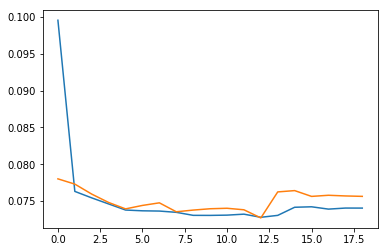

아ᄂ------------------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.---------------------------------------<eos><eos>
아ᄂᄋᆻ다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


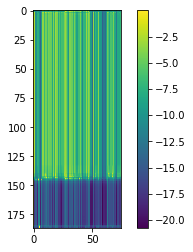

아ᄂ-------------------------------------------------------------------------------------------------------------------ᄋᆻ다.---------------------------------<eos><eos>
아ᄂᄋᆻ다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


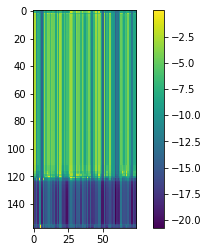

-------------------------------------------------------------------------------------------------------
09-02 13:24:29
Mean Train Loss: 0.07387500568004964
Mean Evaluation Loss: 0.07533776165194757
-------------------------------------------------------------------------------------------------------
09-02 13:25:53
Mean Train Loss: 0.0737058519717322
Mean Evaluation Loss: 0.07554356466327863
-------------------------------------------------------------------------------------------------------
09-02 13:27:18
Mean Train Loss: 0.07395062476440516
Mean Evaluation Loss: 0.07573346240521846
-------------------------------------------------------------------------------------------------------
09-02 13:28:43
Mean Train Loss: 0.07405196795178429
Mean Evaluation Loss: 0.07591183322382726
-------------------------------------------------------------------------------------------------------
09-02 13:30:09
Mean Train Loss: 0.07402666351957929
Mean Evaluation Loss: 0.07560002894955382
-----------

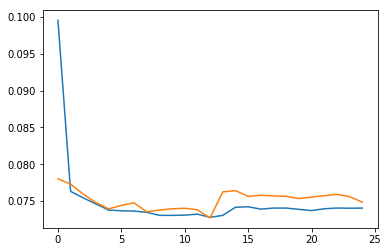

아ᄂ--------------------------------------------------------------------------------------------------------------------------------ᅡᆻ다.--------------------------------<eos><eos>
아났다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


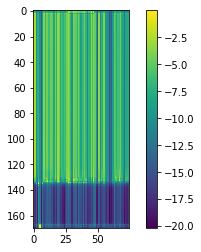

아ᄂ---------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


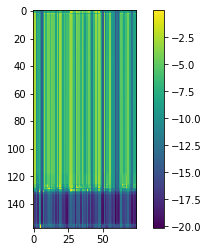

-------------------------------------------------------------------------------------------------------
09-02 13:32:59
Mean Train Loss: 0.07339494389373323
Mean Evaluation Loss: 0.07574554084021679
-------------------------------------------------------------------------------------------------------
09-02 13:34:25
Mean Train Loss: 0.07399305200859914
Mean Evaluation Loss: 0.07553215673899308
-------------------------------------------------------------------------------------------------------
09-02 13:35:51
Mean Train Loss: 0.07384278587709596
Mean Evaluation Loss: 0.07530650686783884
-------------------------------------------------------------------------------------------------------
09-02 13:37:16
Mean Train Loss: 0.07364008597714763
Mean Evaluation Loss: 0.07550356649486924
-------------------------------------------------------------------------------------------------------
09-02 13:38:41
Mean Train Loss: 0.07361809467002284
Mean Evaluation Loss: 0.07558428559072247
----------

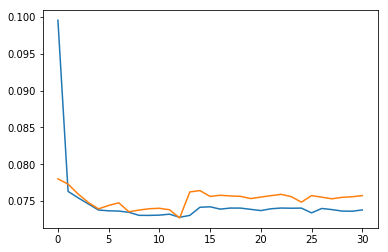

아ᄂ-----------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.---------------------------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


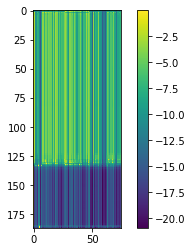

아ᄂ----------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.-----------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


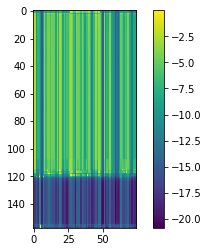

-------------------------------------------------------------------------------------------------------
09-02 13:41:32
Mean Train Loss: 0.07389495380237647
Mean Evaluation Loss: 0.07607966873757037
-------------------------------------------------------------------------------------------------------
09-02 13:42:57
Mean Train Loss: 0.07384213835207107
Mean Evaluation Loss: 0.07601423393097861
-------------------------------------------------------------------------------------------------------
09-02 13:44:23
Mean Train Loss: 0.07385209552167257
Mean Evaluation Loss: 0.0752152267333415
-------------------------------------------------------------------------------------------------------
09-02 13:45:48
Mean Train Loss: 0.07353021715790656
Mean Evaluation Loss: 0.07562740508979914
-------------------------------------------------------------------------------------------------------
09-02 13:47:13
Mean Train Loss: 0.073817813968832
Mean Evaluation Loss: 0.07548275575265771
-------------

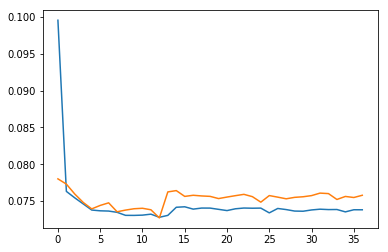

아ᄂ--------------------------------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


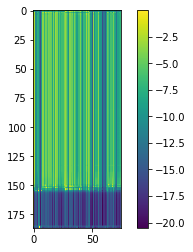

아ᄂ----------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.-----------------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


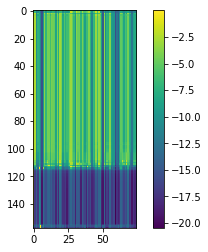

-------------------------------------------------------------------------------------------------------
09-02 13:50:05
Mean Train Loss: 0.07391018021490611
Mean Evaluation Loss: 0.07500746841924463
-------------------------------------------------------------------------------------------------------
09-02 13:51:29
Mean Train Loss: 0.07365473284329344
Mean Evaluation Loss: 0.07568040527500719
-------------------------------------------------------------------------------------------------------
09-02 13:52:54
Mean Train Loss: 0.0738831908194945
Mean Evaluation Loss: 0.0762543614819856
-------------------------------------------------------------------------------------------------------
09-02 13:54:19
Mean Train Loss: 0.07308075717213619
Mean Evaluation Loss: 0.07612692672202807
-------------------------------------------------------------------------------------------------------
09-02 13:55:44
Mean Train Loss: 0.07367401724952016
Mean Evaluation Loss: 0.07604893973633957
------------

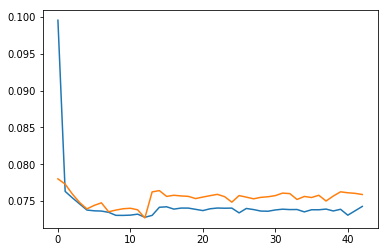

아ᄂ--------------------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.-------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


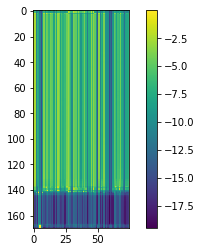

아ᄂ---------------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


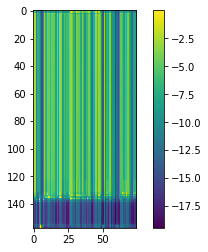

-------------------------------------------------------------------------------------------------------
09-02 13:58:35
Mean Train Loss: 0.07409762045341185
Mean Evaluation Loss: 0.07607353014713072
-------------------------------------------------------------------------------------------------------
09-02 14:00:00
Mean Train Loss: 0.07390710865216402
Mean Evaluation Loss: 0.07598333774386123
-------------------------------------------------------------------------------------------------------
09-02 14:01:25
Mean Train Loss: 0.07397689346064963
Mean Evaluation Loss: 0.07566508457212699
-------------------------------------------------------------------------------------------------------
09-02 14:02:51
Mean Train Loss: 0.07407782924896616
Mean Evaluation Loss: 0.07551607485440749
-------------------------------------------------------------------------------------------------------
09-02 14:04:16
Mean Train Loss: 0.07375287771248336
Mean Evaluation Loss: 0.07541430886646541
----------

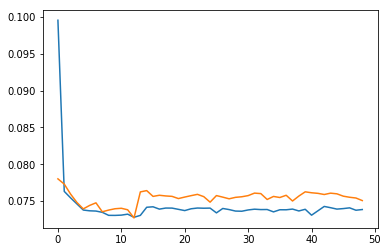

아ᄂ----------------------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.----------------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


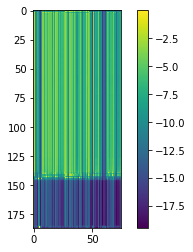

아ᄂ-------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.--------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


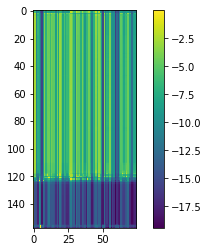

-------------------------------------------------------------------------------------------------------
09-02 14:07:08
Mean Train Loss: 0.07360954065830241
Mean Evaluation Loss: 0.07535840414401304
-------------------------------------------------------------------------------------------------------
09-02 14:08:34
Mean Train Loss: 0.07371719126698552
Mean Evaluation Loss: 0.0748710002248371
-------------------------------------------------------------------------------------------------------
09-02 14:09:59
Mean Train Loss: 0.07354341910981634
Mean Evaluation Loss: 0.0749538427890734
-------------------------------------------------------------------------------------------------------
09-02 14:11:25
Mean Train Loss: 0.07353911164169448
Mean Evaluation Loss: 0.07546914599970285
-------------------------------------------------------------------------------------------------------
09-02 14:12:51
Mean Train Loss: 0.0759671088856865
Mean Evaluation Loss: 0.07385618673696134
-------------

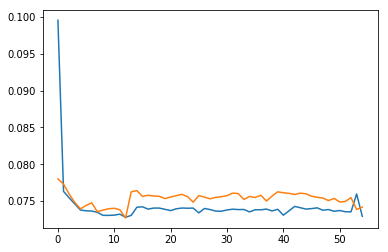

아ᄂ-------------------------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.--------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


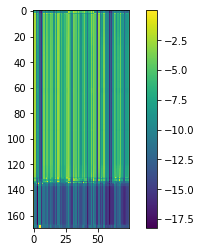

아ᄂ----------------------------------------------------------------------------------------------------ᆸ이다.-----------------------------------------------<eos><eos>
아ᄂᆸ이다.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


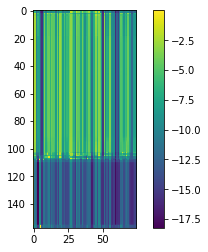

-------------------------------------------------------------------------------------------------------
09-02 14:15:43
Mean Train Loss: 0.07308305243871169
Mean Evaluation Loss: 0.0736402106397564
-------------------------------------------------------------------------------------------------------
09-02 14:17:08
Mean Train Loss: 0.07338426900891287
Mean Evaluation Loss: 0.07555822378390527
-------------------------------------------------------------------------------------------------------
09-02 14:18:34
Mean Train Loss: 0.07371137281038671
Mean Evaluation Loss: 0.07496599418267226
-------------------------------------------------------------------------------------------------------
09-02 14:19:59
Mean Train Loss: 0.07357135332717372
Mean Evaluation Loss: 0.07514310885685507
-------------------------------------------------------------------------------------------------------
09-02 14:21:25
Mean Train Loss: 0.07380218329286892
Mean Evaluation Loss: 0.07509430591937108
-----------

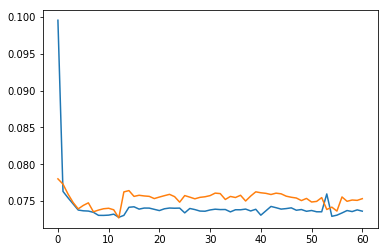

아ᄂ---------------------------------------------------------------------------------------------------------------------------------------------------ᆻᄋᆻ다.-----------------------------<eos><eos>
아ᄂᆻᄋᆻ다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


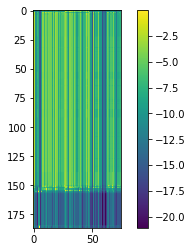

아ᄂ-----------------------------------------------------------------------------------------------------------------ᆸᄋᆻ다.----------------------------------<eos><eos>
아ᄂᆸᄋᆻ다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


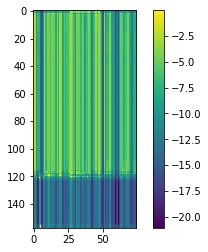

-------------------------------------------------------------------------------------------------------
09-02 14:24:16
Mean Train Loss: 0.07368626300852371
Mean Evaluation Loss: 0.07514241604623523
-------------------------------------------------------------------------------------------------------
09-02 14:25:41
Mean Train Loss: 0.07376029360215794
Mean Evaluation Loss: 0.07493530451707445
-------------------------------------------------------------------------------------------------------
09-02 14:27:06
Mean Train Loss: 0.07353104356075797
Mean Evaluation Loss: 0.07506505009027954
-------------------------------------------------------------------------------------------------------
09-02 14:28:32
Mean Train Loss: 0.07341865364851131
Mean Evaluation Loss: 0.0751454438223638
-------------------------------------------------------------------------------------------------------
09-02 14:29:57
Mean Train Loss: 0.0736385860593095
Mean Evaluation Loss: 0.07500891111899782
------------

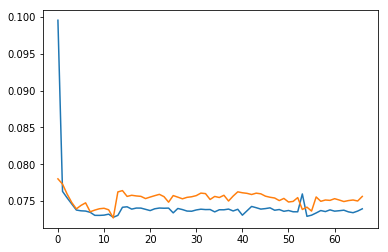

아ᄂ-----------------------------------------------------------------------------------------------------------------------------------------ᆻ다.------------------------<eos><eos>
아ᄂᆻ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


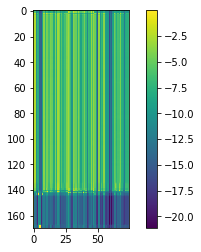

아ᄂ----------------------------------------------------------------------------------------------------------------------------------ᆻ다.-------------------<eos><eos>
아ᄂᆻ다.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


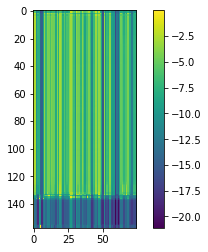

-------------------------------------------------------------------------------------------------------
09-02 14:32:47
Mean Train Loss: 0.07433043980952972
Mean Evaluation Loss: 0.0758436388352211
-------------------------------------------------------------------------------------------------------
09-02 14:34:12
Mean Train Loss: 0.07431473151581286
Mean Evaluation Loss: 0.07523094205060411
-------------------------------------------------------------------------------------------------------
09-02 14:35:38
Mean Train Loss: 0.07425810498585306
Mean Evaluation Loss: 0.07540760308692557
-------------------------------------------------------------------------------------------------------
09-02 14:37:03
Mean Train Loss: 0.07418124638525664
Mean Evaluation Loss: 0.07523479248739197
-------------------------------------------------------------------------------------------------------
09-02 14:38:28
Mean Train Loss: 0.07422646224951421
Mean Evaluation Loss: 0.07863749456545632
-----------

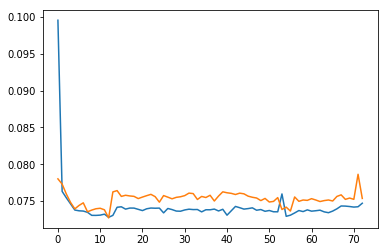

아--------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.---------------------------------<eos><eos>
아ᄋᆻ다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


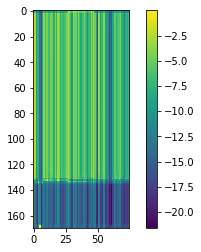

아-------------------------------------------------------------------------------------------------------------------ᄋᆻ다.----------------------------------<eos><eos>
아ᄋᆻ다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


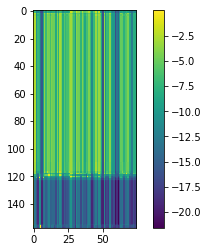

-------------------------------------------------------------------------------------------------------
09-02 14:41:18
Mean Train Loss: 0.07409943569617164
Mean Evaluation Loss: 0.07590951633422353
-------------------------------------------------------------------------------------------------------
09-02 14:42:42
Mean Train Loss: 0.07429265448306761
Mean Evaluation Loss: 0.07524571891588577
-------------------------------------------------------------------------------------------------------
09-02 14:44:07
Mean Train Loss: 0.07415025054228766
Mean Evaluation Loss: 0.07546103041424311
-------------------------------------------------------------------------------------------------------
09-02 14:45:32
Mean Train Loss: 0.07422846645375235
Mean Evaluation Loss: 0.07551165171408811
-------------------------------------------------------------------------------------------------------
09-02 14:46:56
Mean Train Loss: 0.0743114445567425
Mean Evaluation Loss: 0.07533872364173314
-----------

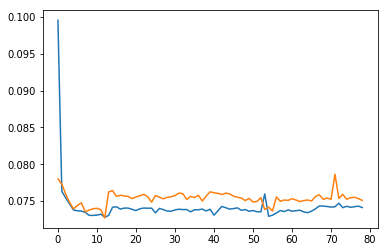

아--------------------------------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.---------<eos><eos>
아ᄋᆻ다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


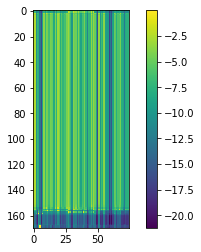

아------------------------------------------------------------------------------------------------------------ᄋᆻ다.-----------------------------------------<eos><eos>
아ᄋᆻ다.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


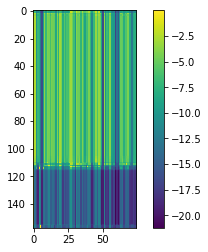

-------------------------------------------------------------------------------------------------------
09-02 14:49:45
Mean Train Loss: 0.07390120109492124
Mean Evaluation Loss: 0.07515211458874237
-------------------------------------------------------------------------------------------------------
09-02 14:51:10
Mean Train Loss: 0.07378862027014511
Mean Evaluation Loss: 0.07486461728721971
-------------------------------------------------------------------------------------------------------
09-02 14:52:34
Mean Train Loss: 0.0736100430451292
Mean Evaluation Loss: 0.07502580926693367
-------------------------------------------------------------------------------------------------------
09-02 14:53:59
Mean Train Loss: 0.07354594990729067
Mean Evaluation Loss: 0.07566021755342787
-------------------------------------------------------------------------------------------------------
09-02 14:55:24
Mean Train Loss: 0.07388147847098064
Mean Evaluation Loss: 0.07609026676827896
-----------

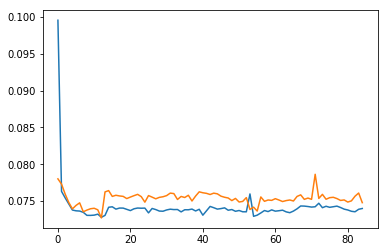

아---------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.--------------------------------------<eos><eos>
아ᄋᆻ다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


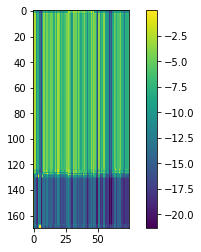

아--------------------------------------------------------------------------------------------------------------------ᄋᆻ다.---------------------------------<eos><eos>
아ᄋᆻ다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


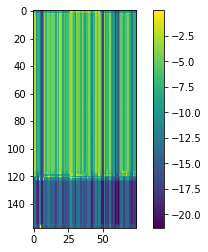

-------------------------------------------------------------------------------------------------------
09-02 14:58:14
Mean Train Loss: 0.07361013392660144
Mean Evaluation Loss: 0.07520397489410083
-------------------------------------------------------------------------------------------------------
09-02 14:59:38
Mean Train Loss: 0.0738508392640746
Mean Evaluation Loss: 0.07495981514845249
-------------------------------------------------------------------------------------------------------
09-02 15:01:03
Mean Train Loss: 0.07374665376634781
Mean Evaluation Loss: 0.07522441866629229
-------------------------------------------------------------------------------------------------------
09-02 15:02:27
Mean Train Loss: 0.07371783420210297
Mean Evaluation Loss: 0.0752972695490382
-------------------------------------------------------------------------------------------------------
09-02 15:03:52
Mean Train Loss: 0.07420196803027938
Mean Evaluation Loss: 0.07524810982149538
------------

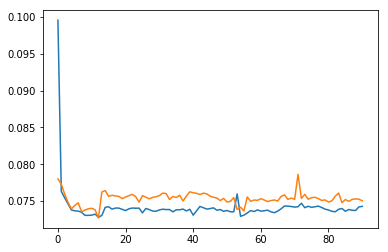

아ᄂ-------------------------------------------------------------------------------------------------------------------------------------------다.----------------------------------------<eos><eos>
아ᄂ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


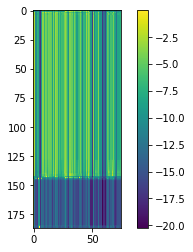

아ᄂ--------------------------------------------------------------------------------------------------------------다.----------------------------------------<eos><eos>
아ᄂ다.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


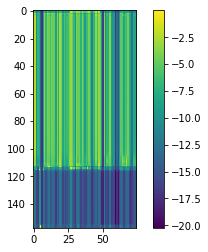

-------------------------------------------------------------------------------------------------------
09-02 15:06:42
Mean Train Loss: 0.07363215635453815
Mean Evaluation Loss: 0.07631637450301221
-------------------------------------------------------------------------------------------------------
09-02 15:08:06
Mean Train Loss: 0.07423146300186752
Mean Evaluation Loss: 0.07493884467188781
-------------------------------------------------------------------------------------------------------
09-02 15:09:30
Mean Train Loss: 0.07370716412644064
Mean Evaluation Loss: 0.07543146620837045
-------------------------------------------------------------------------------------------------------
09-02 15:10:54
Mean Train Loss: 0.07371963080111471
Mean Evaluation Loss: 0.07469277947584455
-------------------------------------------------------------------------------------------------------
09-02 15:12:19
Mean Train Loss: 0.07382305069613931
Mean Evaluation Loss: 0.07489776320999132
----------

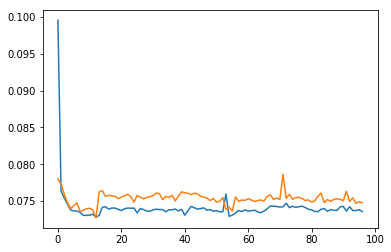

아ᄂ----------------------------------------------------------------------------------------------------------------------------------------------------ᆻ다.------------------------------<eos><eos>
아ᄂᆻ다.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


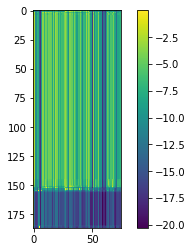

아ᄂ-----------------------------------------------------------------------------------------------------ᆻ다.------------------------------------------------<eos><eos>
아ᄂᆻ다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


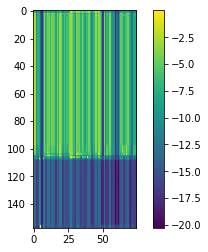

-------------------------------------------------------------------------------------------------------
09-02 15:15:08
Mean Train Loss: 0.07375176899979445
Mean Evaluation Loss: 0.07609725937349193
-------------------------------------------------------------------------------------------------------
09-02 15:16:31
Mean Train Loss: 0.07409431124828975
Mean Evaluation Loss: 0.07480974523946068
-------------------------------------------------------------------------------------------------------
09-02 15:17:55
Mean Train Loss: 0.07368637595812881
Mean Evaluation Loss: 0.07618384669207323
-------------------------------------------------------------------------------------------------------
09-02 15:19:19
Mean Train Loss: 0.0738672726265192
Mean Evaluation Loss: 0.07493849451221093
-------------------------------------------------------------------------------------------------------
09-02 15:20:43
Mean Train Loss: 0.07361497071841747
Mean Evaluation Loss: 0.07501545911644736
-----------

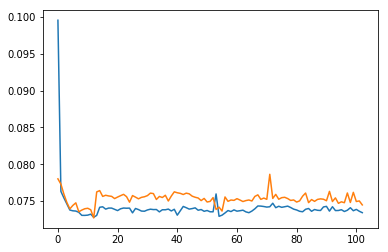

아ᄂ------------------------------------------------------------------------------------------------------------------------------------ᆻ다.----------------------------------------------<eos><eos>
아ᄂᆻ다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


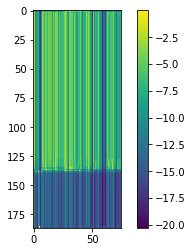

아ᄂ---------------------------------------------------------------------------------------------------------------------ᄋᆻ다.-------------------------------<eos><eos>
아ᄂᄋᆻ다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


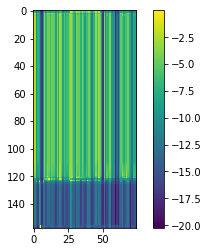

-------------------------------------------------------------------------------------------------------
09-02 15:23:32
Mean Train Loss: 0.07350813523770747
Mean Evaluation Loss: 0.0751937062476999
-------------------------------------------------------------------------------------------------------
09-02 15:24:56
Mean Train Loss: 0.07372062360321155
Mean Evaluation Loss: 0.07474867911481262
-------------------------------------------------------------------------------------------------------
09-02 15:26:19
Mean Train Loss: 0.07360706891412117
Mean Evaluation Loss: 0.0749536287380866
-------------------------------------------------------------------------------------------------------
09-02 15:27:45
Mean Train Loss: 0.07355602071371817
Mean Evaluation Loss: 0.07571843872186922
-------------------------------------------------------------------------------------------------------
09-02 15:29:08


KeyboardInterrupt: ignored

In [27]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_deep_2')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_test.initialize_batch()
    loss_list_eval = list()
    
    while preloader_test.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_test.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_deep_2')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_deep_2.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_deep_2.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")